# Wiktor Ciołek 311501 SATFD laboratory 6 11.06.2024

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import dct, idct

import pgm_reader

plt.rcParams['font.size'] = 12
plt.rcParams['figure.facecolor'] = 'grey'

# Introduction
In this laboratory exercise a JPEG compression standard is implemented and tested. This stadard's process chain is following:
1. **Discrete Cosine Transform (DCT)** which is ideologically similar to Fourier Transform. It can be obtained by matrix operation defined, where X is transformed signal and Y is transform output: $$Y = CXC^T$$ C matrix is is composed of different frequency cosine functions. In the notebook it is named DCT
2. **Quantization**. Quantization is obtained by element wise division of each matrix element on the output of DCT transform. In the notebook, 2 different quantization matrices $\hat{q}$ are used. In each of them, elemnts with lower indices are smaller. In this way higher spatial frequencies are eliminated. Before the next step, each matrix element is rounded down to the nearest integer. This step is vital for the irreversibility of the quantization-dequantization process and more importantly to obtain some zero-elemnts in the end which is what compression is all about. $$Y^{(q)}_ij = \lfloor Y_{ij} / q_{ij} \rfloor$$
3. **Dequantization** The resulting matrix from the last step is then multiplied by the same quantization matrix. In this way, one obtains cosine transform matrix but with some higher frequencies eliminated
4. **Inverse DCT** Inverse DCT or, in other words, DCT of 3rd type is performed by reversing the matrix operations. $$X = C^T YC$$

In [19]:
def show_image(data, title=None, vmin=0, vmax=255):
    plt.gray()
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=22)
    plt.imshow(data, vmin=vmin, vmax=vmax)

Codec: b'P5\n'
Reading P5 maps


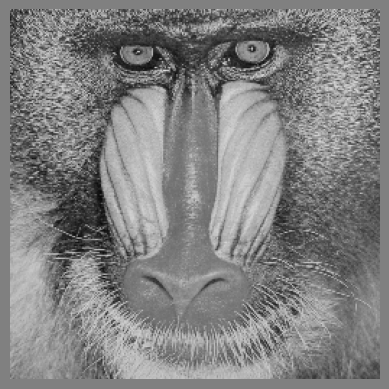

In [20]:
image_path = './pgms/mandrill.pgm'
reader = pgm_reader.Reader()
X = reader.read_pgm(image_path)

show_image(X)

In [21]:
import math

def compress_JPG(X:np.ndarray, q_mat:np.ndarray, N:int = 8, plot_steps:bool = False) -> np.ndarray:
    """
    Compress 1-channel image `X` with DCT standard and PLOT (if 'plot' = true) the subsequent steps. The steps involved are:
     - Block division into `N` x `N` blocks
     - DCT transform
     - Quantization with `q_mat`
     - rounding down resulting coefficients
     - dequantization
     - inverse DCT

    # Returns:
     Compressed image as 2D - array
    """

    if q_mat.shape[0] > N and q_mat.shape[1] > N:
        q_mat = q_mat[:N, :N]
        print("Quantization matrix was cut to be the same shape as each block")
    elif q_mat.shape[0] < N and q_mat.shape[1] < N:
        q_mat = np.pad(q_mat, constant_values=q_mat.max(), pad_width=((0, N - q_mat.shape[0]), (0, N - q_mat.shape[1])))
        print("Quantization padded to be the same shape as each block")

    # source: https://dev.to/marycheung021213/understanding-dct-and-quantization-in-jpeg-compression-1col
    DCT=np.zeros((N,N))
    for m in range(N):
        for n in range(N):
            if m==0:
                DCT[m][n]=math.sqrt(1/N)
            else:
                DCT[m][n]=math.sqrt(2/N)*math.cos((2*n+1)*math.pi*m/(2*N))

    y_size, x_size = X.shape
    X = np.pad(X, constant_values=0, pad_width=((0, (N-y_size%N)%N), (0, (N-x_size%N)%N)))
    y_size, x_size = X.shape

    X_dct = np.zeros_like(X)
    X_q = np.zeros_like(X)
    X_iq = np.zeros_like(X)
    X_cmp = np.zeros_like(X)

    for i in range(0, y_size, N):
        for j in range(0, x_size, N):
            # get DCT coefficients (DCT 2nd type)
            X_dct[i:i+N, j:j+N] = DCT @ X[i:i+N, j:j+N] @ DCT.T
            # apply quantization with element-wise division and round down 
            X_q[i:i+N, j:j+N] = np.floor(X_dct[i:i+N, j:j+N] / q_mat)
            # revert quantization
            X_iq[i:i+N, j:j+N] = X_q[i:i+N, j:j+N] * q_mat
            # Inverse DCT (DCT 3rd type)
            X_cmp[i:i+N, j:j+N] = DCT.T @ X_iq[i:i+N, j:j+N] @ DCT

    if plot_steps:
        plt.figure(figsize=(22, 12))
        plt.subplot(2, 3, 1)
        show_image(X, 'Original')
        plt.subplot(2, 3, 2)
        show_image(X_dct, 'DCT coeff')
        plt.subplot(2, 3, 3)
        show_image(X_q, 'Quantizied')
        plt.subplot(2, 3, 4)
        show_image(X_iq, 'Dequantizied')
        plt.subplot(2, 3, 5)
        show_image(X_cmp, 'Compressed')
        plt.subplot(2, 3, 6)
        # new_zeros = (X_cmp == 0).astype(int) - (X == 0).astype(int)
        show_image(((X_cmp == 0) * 255), "Zero elements")

        plt.tight_layout()

        zero_frac = (X_cmp == 0).sum() / X_cmp.shape[0] / X_cmp.shape[1]
        print(f'Fraction of zero elements in compressed image is {zero_frac:.5f}')

    return X_cmp

# Ilumination matrix and 8 size block
During the process described in introduction each image is usually divided into NxN pixel blocks and each block undergoes those 4 operations. In this cells N=8 is tested, which is the most frequent choice. Ilumination matrix is applied as quantization matrix. It's feature is slowly increasing value of greater indices elements.

In [22]:
N = 8

q_iluminance = np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])

Fraction of zero elements in compressed image is 0.00104


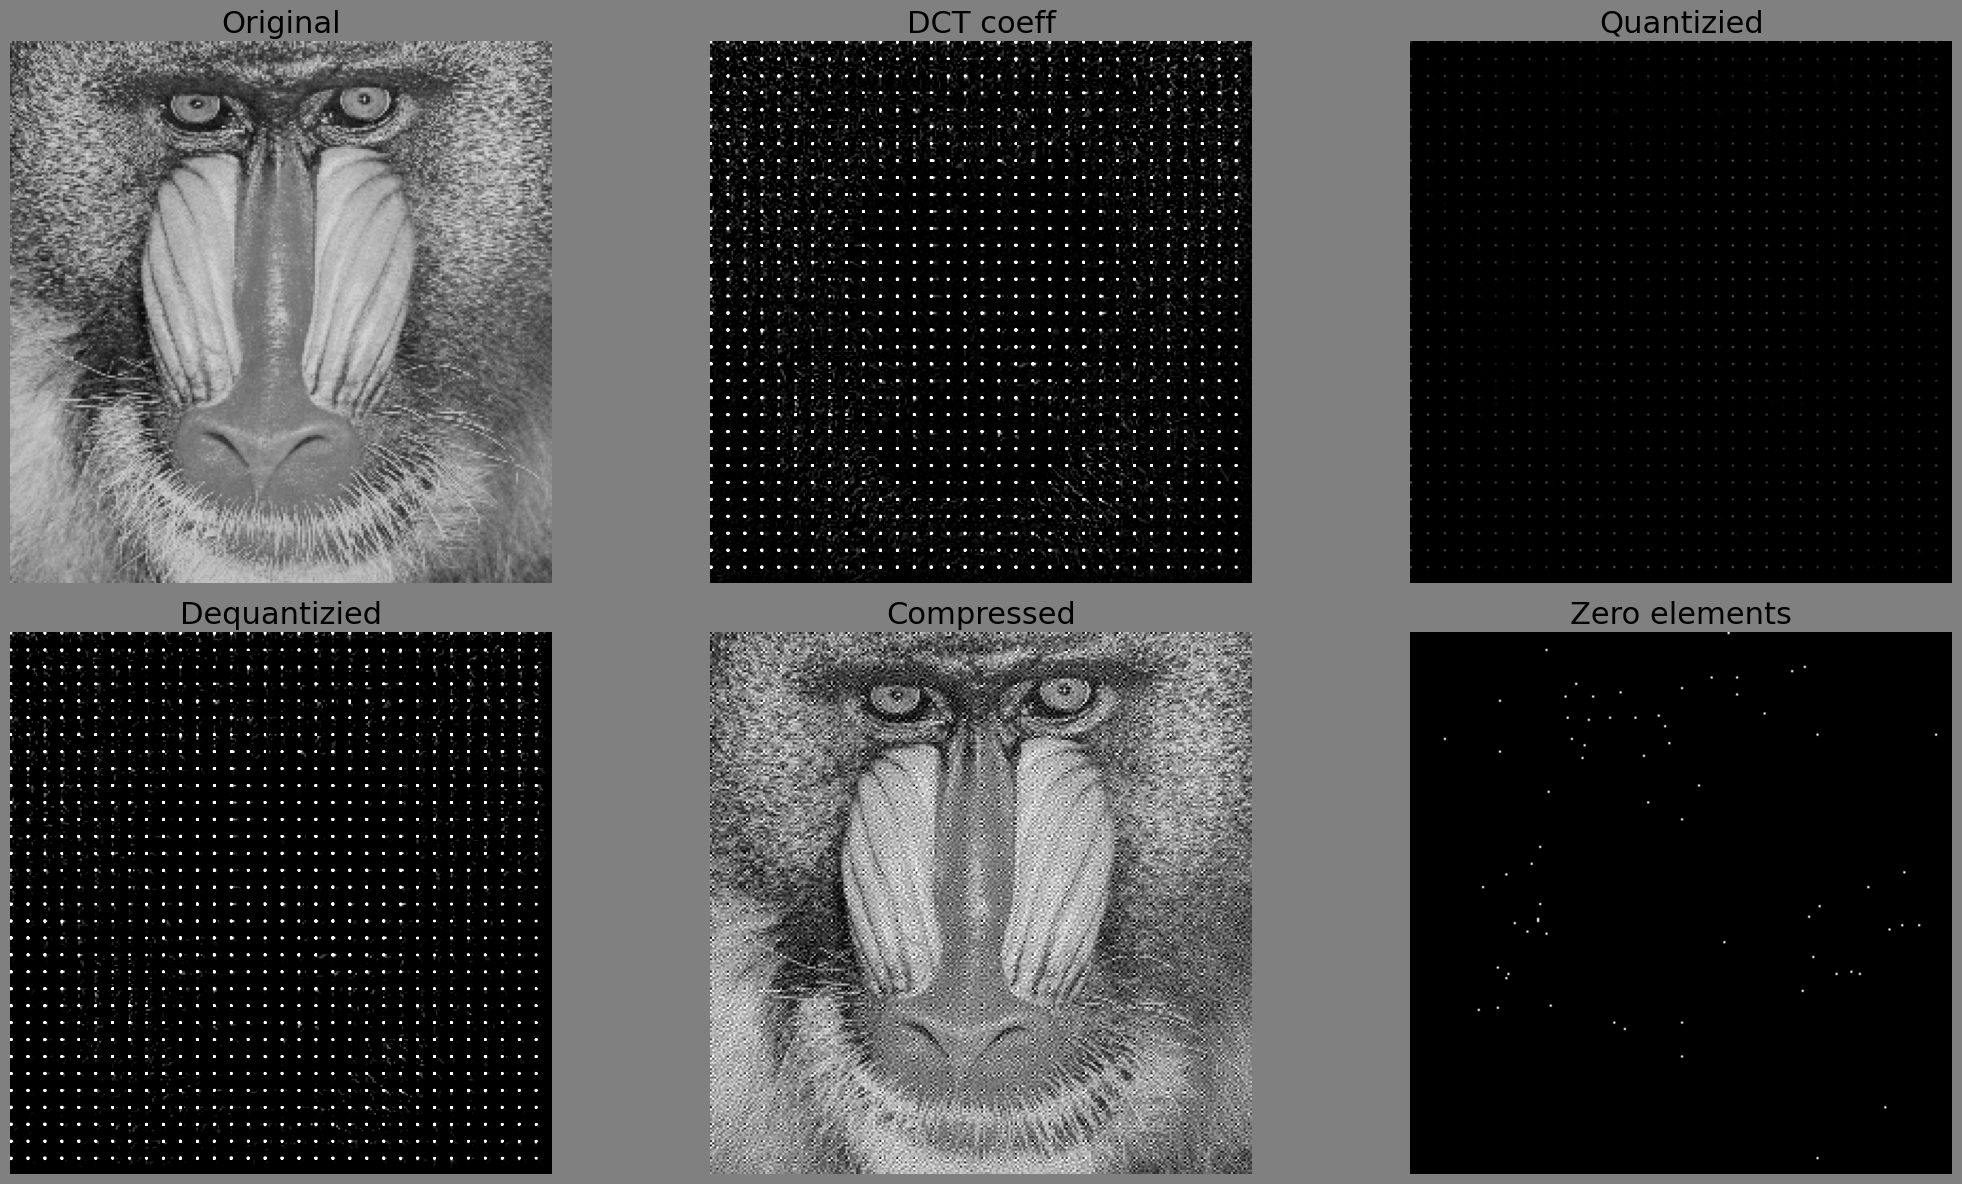

In [23]:
X_cmp = compress_JPG(X, q_iluminance, N, plot_steps=True)

# Chrominance matrix and N=48 blocks
This time a greater block size is chosen. To create full-size block the image has to be padded with zeros on the left and bottom which is done in this example. Chrominance matrix is different from the previous one as it has sudden increase of division elements.

In [24]:
N = 48

q_chrominance = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

Quantization padded to be the same shape as each block
Fraction of zero elements in compressed image is 0.00735


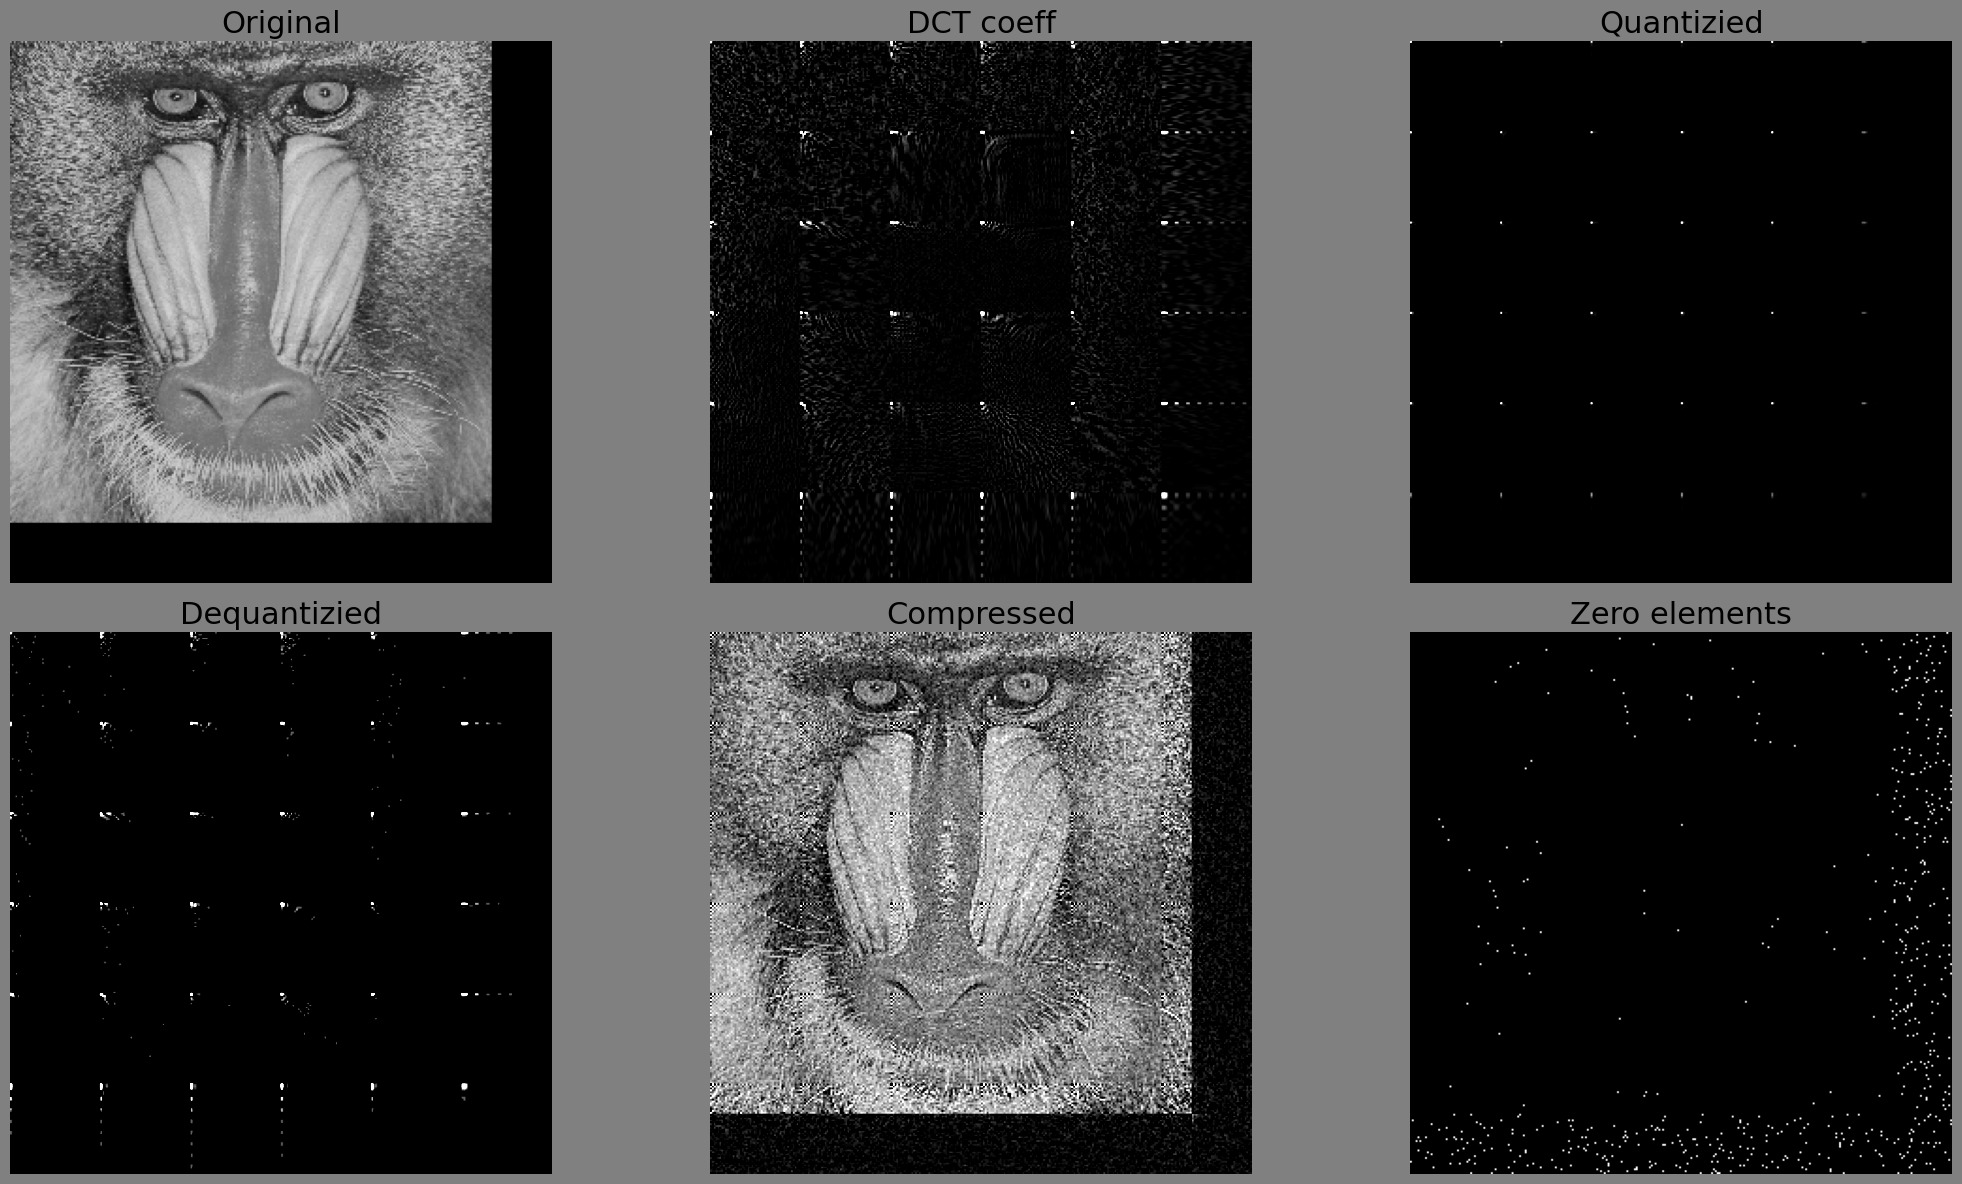

In [25]:
X_cmp = compress_JPG(X, q_chrominance, N, plot_steps=True)

# Observations and conclusions
Second option results in greater image quality decrease and it should be concluded that greater block size is responsible for that. However, it results in more zero-elemnts in the resulting matrix, which allows for greater data compression. No difference between two tested quantization matrices was observed. 